# Import library

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
import cv2
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Model



%matplotlib inline

# Grad Cam and Attention function

## Grad Cam

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img, heatmap, alpha=0.4):
    # Load the original image
    #img = tf.keras.preprocessing.image.load_img(img_path)
    #img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    #display(superimposed_img)
    return superimposed_img

## Attention function

In [ ]:

class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])

In [ ]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

# Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%cd "/content/drive/MyDrive/Academia/Research/Computer Vision/Earthquake_damage_detection/Data"
%cd "/content/drive/My Drive/Study/HonorThesis/"

/content/drive/My Drive/Study/HonorThesis


In [ ]:
df = pd.read_csv (r"Predictors_Linear_regression_columns.csv")

In [ ]:
df

,1111,1112,1113,1121,1122,1123,1131,1132,1133,1211,1212,1213,1221,1222,1223,1231,1232,1233,1311,1312,1313,1321,1322,1323,1331,1332,1333,2111,2112,2113,2121,2122,2123,2131,2132,2133,2211,2212,2213,2221,...,2312,2313,2321,2322,2323,2331,2332,2333,3111,3112,3113,3121,3122,3123,3131,3132,3133,3211,3212,3213,3221,3222,3223,3231,3232,3233,3311,3312,3313,3321,3322,3323,3331,3332,3333,maxDrift,File,Pic ID,Cycle ID,Group
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.180,IMG_0035,IMG_0035.JPG,c7-,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0.180,IMG_0042,IMG_0042.JPG,c7-,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0.180,IMG_1314,IMG_1314.JPG,c7-,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.180,IMG_1315,IMG_1315.JPG,c7-,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0.180,IMG_1316,IMG_1316.JPG,c7-,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.024,IMG_1356,IMG_1356.JPG,c24+,28
92,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,2,1,1,0,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.027,IMG_0136,IMG_0136.JPG,c25+,29
93,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,1,2,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.027,IMG_0137,IMG_0137.JPG,c25+,29
94,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,2,1,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.027,IMG_0139,IMG_0139.JPG,c25+,29


In [ ]:
dataMaxDrift = [] #labels
imageLst = []     
groupName = []    # group to working on kfold

#store value after train
Store_history = []
mae_per_fold = []
Loss_per_fold = []
test_predictions = []
actual_values = []
predict_images = []
store_model = []
store_cnn = []

Str_path = 'Data4/'
img_height = 320
img_width = 320
numb_epochs = 200

In [ ]:
for i in range(df[df.columns[0]].count()):
    #make a path to image
    a = Str_path + str(df['Cycle ID'][i]) + "/" + str(df['Pic ID'][i])
    #read image, resize and add into list
    image = cv2.imread(a)
    image = cv2.resize(image, (img_height, img_width))
    imageLst.append(image)

    #add label value into list
    b = df['maxDrift'][i]
    if b < 0:
        b = abs(b)
    dataMaxDrift.append(b)
    
    #add group name for kFold
    groupName.append(df['Group'][i])

In [ ]:
x_sample = df.drop(["maxDrift",'File','Pic ID', 'Cycle ID','Group'], axis=1)
x_sample = np.array(x_sample)

In [ ]:
x_sample.shape

(96, 81)

In [ ]:
img = np.array(imageLst)

In [ ]:
input_data = zip(x_sample, img)

In [ ]:
y = df['maxDrift']
y = np.array(y)

In [ ]:
input_data = list(input_data)

In [ ]:
len(input_data)

96

# Build Model

In [ ]:
def create_mlp(dim, regularizer=None):
    """Creates a simple two-layer MLP with inputs of the given dimension"""
    model_1 = tf.keras.models.Sequential([
      tf.keras.layers.Dense(64,input_dim=dim, activation='relu', kernel_regularizer=regularizer),
      tf.keras.layers.Dense(1, activation='linear')])
    
    return model_1

In [ ]:


def create_cnn(width, height, depth, regularizer=None):
    """
    Creates a CNN with the given input dimension and filter numbers.
    """
    inputShape = (height, width, depth)
    inputs = tf.keras.layers.Input(shape=inputShape)
    
    x = inputs

    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)
    x = tf.keras.layers.experimental.preprocessing.RandomContrast(0.3)(x)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.01)(x)
 
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

    x = ChannelAttention(64, 8)(x)
    x = SpatialAttention(7)(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)
    
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

    x = ChannelAttention(64, 8)(x)
    x = SpatialAttention(7)(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(units=512, activation='relu')(x)
    x = tf.keras.layers.Dense(units=128, activation='relu')(x)
    x = tf.keras.layers.Dense(units=1, activation = 'linear')(x)

    model = Model(inputs, x)
    # Return the CNN
    return model      

In [ ]:
n = 8
gkf = GroupKFold(n_splits = n)

In [ ]:
count = 1 
for train, test in gkf.split(input_data, y, groups = groupName):
    print(f"Start {count} fold with test set data {len(y[test])}")
    print()
    
    new_x, new_img = list(zip(*input_data))
    new_x = np.array(new_x)
    new_img = np.array(new_img)

    mlp_train = create_mlp(new_x.shape[1])
    cnn_train = create_cnn(img_width,img_height,3)

    combineInput = tf.keras.layers.concatenate([mlp_train.output, cnn_train.output])

    x = tf.keras.layers.Dense(4, activation="relu")(combineInput)
    x = tf.keras.layers.Dense(1, activation="linear")(x)

    # The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
    model1 = Model(inputs=[mlp_train.input, cnn_train.input], outputs=x)

    # Compile the model 
    opt = tf.keras.optimizers.Adam(lr=0.001) #decay=1e-3 / 200
    model1.compile(loss="mae", metrics=['mae'], optimizer=opt)
    model1.summary()
    model1_history = model1.fit( [new_x[train], new_img[train]], y[train], 
                            validation_data=([new_x[test], new_img[test]], y[test]), 
                            epochs=numb_epochs,)
    
    #Store value after training
    store_model.append(model1)

    Store_history.append(model1_history)
    store_cnn.append(cnn_train)
    
    predict_image = new_img[test]
    predict_images.append(np.array(predict_image))

    test_prediction = model1.predict([new_x[test], new_img[test]])
    test_predictions.append(np.array(test_prediction))
    
    actual_value = y[test].copy()
    actual_values.append(np.array(actual_value))
    
    
    print(f"Complete save model {count}")
    
    count = count + 1

Start 1 fold with test set data 12



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 320, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
random_contrast (RandomContrast (None, 320, 320, 3)  0           rescaling[0][0]                  
__________________________________________________________________________________________________
random_rotation (RandomRotation (None, 320, 320, 3)  0           random_contrast[0][0]            
____________________________________________________________________________________________

# Visualization result

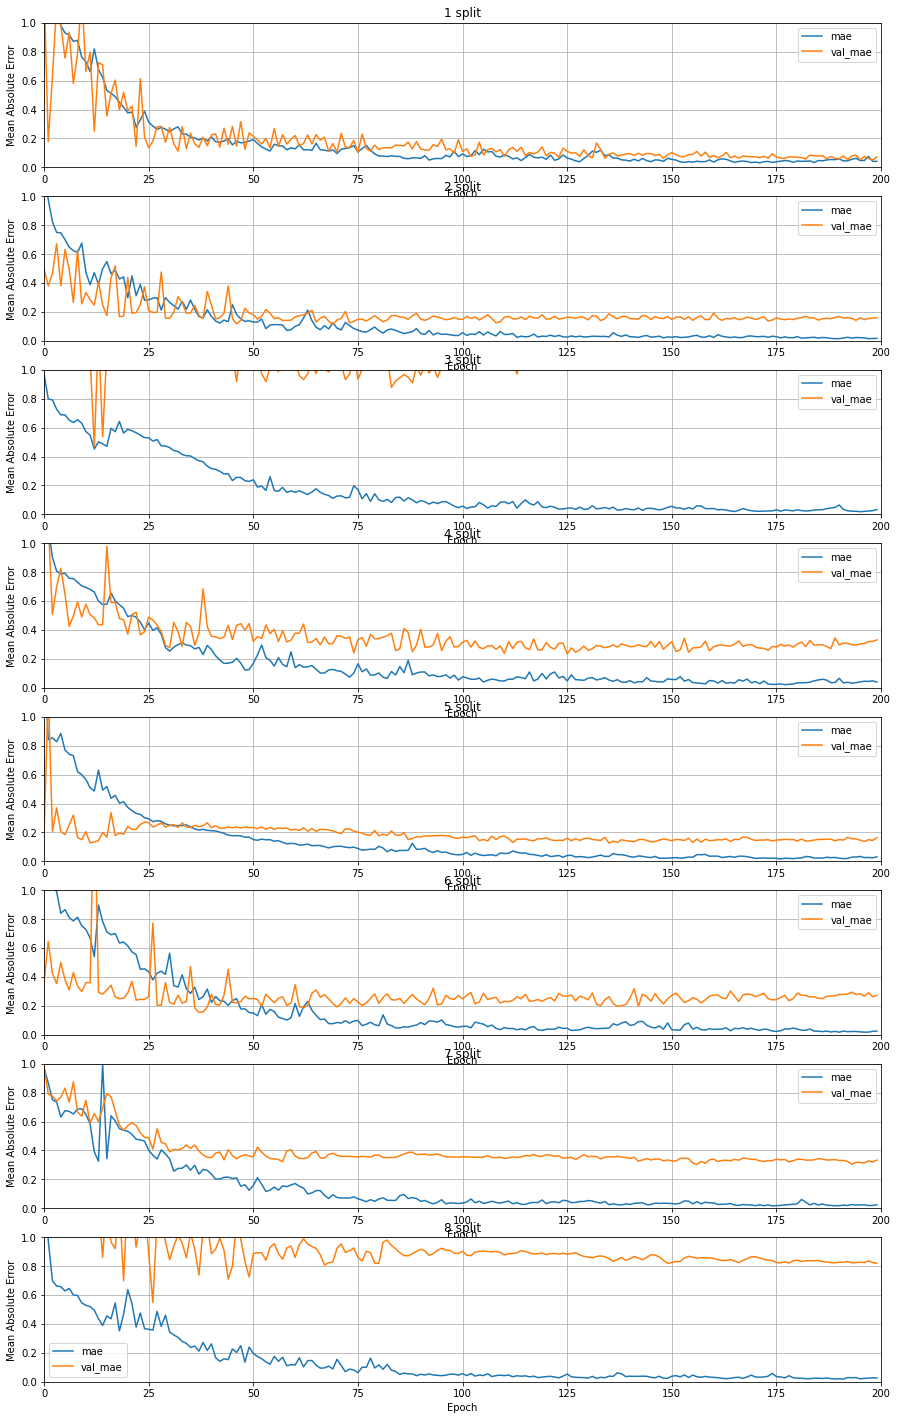

In [ ]:
fig, ax = plt.subplots(figsize=(15,25))
ax.axis("off")
for i in range(n):
     
     plt.subplot(n,1,i+1)
     plt.plot(Store_history[i].history['mae'], label='mae')
     plt.plot(Store_history[i].history['val_mae'], label='val_mae')
     plt.title(f"{i+1} split")
     plt.ylim([0, 1])
     plt.xlim([0,numb_epochs])
     plt.xlabel('Epoch')
     plt.ylabel('Mean Absolute Error')
     plt.legend()
     plt.grid(True)

In [ ]:
test_labels = list(np.concatenate(actual_values).flat)
test_predictions = list(np.concatenate(test_predictions).flat)
test_image = list(np.concatenate(predict_images))

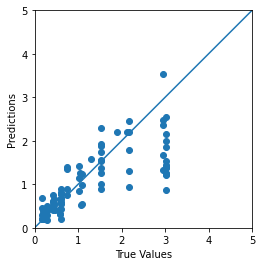

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

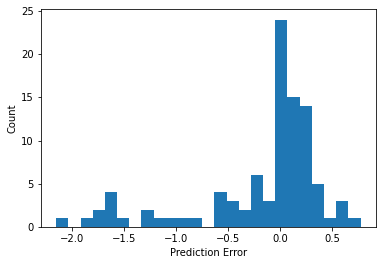

In [ ]:
error = np.array(test_predictions) - np.array(test_labels)
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

#Pick the best model to show grad-cam on whole set data

In [ ]:
plt.figure(figsize=(25,100))
j = 0
count_group = 12
a = 3
check = 0
for i in range(96):
    plt.subplot(12,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    if j > 9:
      break
    my_model = store_cnn[1]

    last_conv = f"conv2d_7"

    img_array = test_image[i]
    img_array = img_array.reshape(1,img_height,img_width,3)
    
    heatmap = make_gradcam_heatmap(img_array, my_model, last_conv)

    plt.imshow(save_and_display_gradcam(test_image[i], heatmap))
    
    #plt.imshow(test_image[i])
    #plt.xlabel("actual: " + "{:.2f}".format(test_labels[i]) + "   predict: " + "{:.2f}".format(test_predictions[i]))
    if check == count_group:
      j +=1
      a += 4
      check = 0
    check += 1
plt.show()

Output hidden; open in https://colab.research.google.com to view.

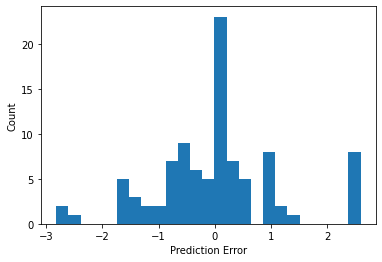

In [ ]:
best_model_pred = store_model[1].predict([x_sample,img])
best_model_pred = np.array(list(np.concatenate(actual_values).flat))
error = best_model_pred - y
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')